

# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from **scratch instead of using any pre-existing libraries** to do so:

(1) Count the frequency of all the N-grams (N=3) and (N=2).

(2) Calculate the probabilities for all the bigrams in the dataset by using the formula  count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative
probabilities of each review in terms of other reviews (abstracts, or tweets) by using the formula  frequency (noun phrase) / max frequency (noun phrase) on the whole dataset.

Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [1]:
import pandas as pd
import re
from collections import defaultdict
import math
import numpy as np

# ============================================================================
# LOAD YOUR DATA
# ============================================================================

# Load the provided CSV file
df = pd.read_csv('cleaned_research_papers.csv')
# Limiting data to 100 datapoints for easier processing
documents = df['cleaned_text'].dropna().astype(str).tolist()[:100]

print(f"Loaded {len(documents)} documents from cleaned_text column")
print(f"First document preview: {documents[0][:100]}...")

# Add these lines to inspect the documents list
print("\nInspecting first 10 documents after loading:")
for i, doc in enumerate(documents[:10]):
    print(f"Doc {i}: '{doc[:50]}...' (Length: {len(doc)})")

# ============================================================================
# Question 1: N-GRAM ANALYSIS (30 points) - FROM SCRATCH
# ============================================================================

print("\n" + "="*80)
print("QUESTION 1: N-GRAM ANALYSIS")
print("="*80)

def preprocess_text(text):
    """Clean and tokenize text"""
    text = text.lower()
    # Keep only letters and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    return tokens

def generate_ngrams(tokens, n):
    """Generate n-grams from token list"""
    ngrams_list = []
    for i in range(len(tokens) - n + 1):
        ngram = tuple(tokens[i:i+n])
        ngrams_list.append(ngram)
    return ngrams_list

def count_ngrams(documents, n):
    """Count n-gram frequencies across all documents"""
    ngram_counts = defaultdict(int)
    for doc in documents:
        tokens = preprocess_text(doc)
        # Add print statement to inspect tokens
        if not tokens:
            print(f"Warning: Document resulted in empty tokens after preprocessing.")
        ngrams = generate_ngrams(tokens, n)
        for ngram in ngrams:
            ngram_counts[ngram] += 1
    return ngram_counts

# ============================================================================
# PART 1: BIGRAM AND TRIGRAM FREQUENCIES
# ============================================================================

# Count bigrams (N=2)
bigram_counts = count_ngrams(documents, 2)
print("\nBIGRAM FREQUENCIES (Top 15):")
print("-"*80)
sorted_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)
for i, (bigram, count) in enumerate(sorted_bigrams[:15], 1):
    print(f"{i:3}. {' '.join(bigram):35} : {count:4}")

# Count trigrams (N=3)
trigram_counts = count_ngrams(documents, 3)
print("\nTRIGRAM FREQUENCIES (Top 15):")
print("-"*80)
sorted_trigrams = sorted(trigram_counts.items(), key=lambda x: x[1], reverse=True)
for i, (trigram, count) in enumerate(sorted_trigrams[:15], 1):
    print(f"{i:3}. {' '.join(trigram):45} : {count:4}")

print(f"\nTotal unique bigrams: {len(bigram_counts)}")
print(f"Total unique trigrams: {len(trigram_counts)}")

# ============================================================================
# PART 2: BIGRAM PROBABILITIES - P(w2|w1) = count(w1,w2) / count(w1)
# ============================================================================

def calculate_bigram_probabilities(documents):
    """Calculate conditional probabilities P(w2|w1)"""
    word_counts = defaultdict(int)
    bigram_counts = defaultdict(int)

    for doc in documents:
        tokens = preprocess_text(doc)
        for token in tokens:
            word_counts[token] += 1

        bigrams = generate_ngrams(tokens, 2)
        for bigram in bigrams:
            bigram_counts[bigram] += 1

    bigram_probs = {}
    for bigram, count in bigram_counts.items():
        w1, w2 = bigram
        probability = count / word_counts[w1] if word_counts[w1] > 0 else 0
        bigram_probs[bigram] = probability

    return bigram_probs, word_counts, bigram_counts

bigram_probabilities, word_counts, bigram_counts = calculate_bigram_probabilities(documents)

print("\nBIGRAM PROBABILITIES (Top 15):")
print("-"*80)
print(f"{'Bigram':<35} {'Count(w1,w2)':<15} {'Count(w1)':<12} {'Probability':<12}")
print("-"*80)

sorted_probs = sorted(bigram_probabilities.items(), key=lambda x: x[1], reverse=True)
for bigram, prob in sorted_probs[:15]:
    w1, w2 = bigram
    bigram_str = f"{w1} {w2}"
    print(f"{bigram_str:<35} {bigram_counts[bigram]:<15} {word_counts[w1]:<12} {prob:.4f}")

# Show most frequent bigrams with probabilities
print("\n\nMOST FREQUENT BIGRAMS WITH PROBABILITIES:")
print("-"*80)
print(f"{'Bigram':<35} {'Count(w1,w2)':<15} {'Count(w1)':<12} {'Probability':<12}")
print("-"*80)

sorted_by_count = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)
for bigram, count in sorted_by_count[:15]:
    w1, w2 = bigram
    bigram_str = f"{w1} {w2}"
    prob = bigram_probabilities.get(bigram, 0)
    print(f"{bigram_str:<35} {count:<15} {word_counts[w1]:<12} {prob:.4f}")

# ============================================================================
# PART 3: NOUN PHRASES AND RELATIVE PROBABILITIES
# ============================================================================

def extract_noun_phrases_from_scratch(text):
    """Extract potential noun phrases (2-3 word sequences)"""
    tokens = preprocess_text(text)
    noun_phrases = []

    # Generate bigrams as noun phrases
    if len(tokens) >= 2:
        for i in range(len(tokens) - 1):
            np = ' '.join(tokens[i:i+2])
            noun_phrases.append(np)

    # Generate trigrams as noun phrases
    if len(tokens) >= 3:
        for i in range(len(tokens) - 2):
            np = ' '.join(tokens[i:i+3])
            noun_phrases.append(np)

    return noun_phrases

def calculate_relative_probabilities(documents):
    """Calculate relative probabilities: freq(np) / max_freq(np)"""
    all_noun_phrases = set()
    doc_noun_phrases = []

    for doc in documents:
        nps = extract_noun_phrases_from_scratch(doc)
        doc_noun_phrases.append(nps)
        all_noun_phrases.update(nps)

    # Count global frequencies
    global_np_counts = defaultdict(int)
    for nps in doc_noun_phrases:
        for np in nps:
            global_np_counts[np] += 1

    max_frequency = max(global_np_counts.values()) if global_np_counts else 1

    # Calculate relative probabilities for each document
    doc_np_probs = []
    for nps in doc_noun_phrases:
        np_freq = defaultdict(int)
        for np in nps:
            np_freq[np] += 1

        np_probs = {}
        for np in all_noun_phrases:
            freq = np_freq.get(np, 0)
            rel_prob = freq / max_frequency
            np_probs[np] = rel_prob

        doc_np_probs.append(np_probs)

    return doc_np_probs, sorted(list(all_noun_phrases)), global_np_counts

doc_np_probabilities, all_nps, global_np_counts = calculate_relative_probabilities(documents)

# Select top 20 most frequent noun phrases
top_nps_by_freq = sorted(global_np_counts.items(), key=lambda x: x[1], reverse=True)[:20]
top_nps = [np for np, _ in top_nps_by_freq]

print("\nRELATIVE PROBABILITIES OF NOUN PHRASES:")
print("-"*80)
print("(Showing first 10 documents and top 20 most frequent noun phrases)")
print()

print("Top 20 Noun Phrases (by global frequency):")
for i, (np, freq) in enumerate(top_nps_by_freq, 1):
    print(f"{i:3}. {np[:50]:50} (freq: {freq})")

print("\n" + "="*80)
print("RELATIVE PROBABILITY MATRIX (First 10 Documents × Top 20 Noun Phrases)")
print("="*80)

# Create DataFrame
np_matrix = []
for i, doc_probs in enumerate(doc_np_probabilities[:10]):
    row = [doc_probs.get(np, 0) for np in top_nps]
    np_matrix.append(row)

truncated_nps = [np[:30] + '...' if len(np) > 30 else np for np in top_nps]

df_np = pd.DataFrame(
    np_matrix,
    columns=truncated_nps,
    index=[f"Doc_{i+1}" for i in range(10)]
)

print(df_np.to_string(float_format=lambda x: f'{x:.4f}'))

print(f"\n[Full matrix has {len(documents)} documents × {len(all_nps)} noun phrases]")
print(f"Max frequency used for normalization: {max(global_np_counts.values()) if global_np_counts else 0}")

Loaded 100 documents from cleaned_text column
First document preview: present fashionmnist new dataset comprising grayscale image fashion product category image per categ...

Inspecting first 10 documents after loading:
Doc 0: 'present fashionmnist new dataset comprising graysc...' (Length: 350)
Doc 1: 'tensorflow interface expressing machine learning a...' (Length: 898)
Doc 2: 'widespread use artificial intelligence system appl...' (Length: 1050)
Doc 3: 'quantitatively investigate machine learning model ...' (Length: 771)
Doc 4: 'machine learning system become ubiquitous surge in...' (Length: 496)
Doc 5: 'goal precipitation nowcasting predict future rainf...' (Length: 716)
Doc 6: 'current age fourth industrial revolution industry ...' (Length: 1097)
Doc 7: 'present open graph benchmark ogb diverse set chall...' (Length: 1050)
Doc 8: 'scikitlearn python module integrating wide range s...' (Length: 464)
Doc 9: 'machine learning model deep neural network dnns vu...' (Length: 1231)

QUEST

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any **pre-existing libraries** to do so.

In [2]:
# ============================================================================
# Question 2: TF-IDF and Document Ranking (25 points) - FROM SCRATCH
# ============================================================================

print("\n\n" + "="*80)
print("QUESTION 2: TF-IDF AND DOCUMENT RANKING")
print("="*80)

def compute_term_frequency(document):
    """Calculate normalized term frequency"""
    tokens = preprocess_text(document)
    tf = defaultdict(int)
    total_terms = len(tokens)

    for token in tokens:
        tf[token] += 1

    # Normalize by document length
    for term in tf:
        tf[term] = tf[term] / total_terms if total_terms > 0 else 0

    return tf

def compute_inverse_document_frequency(documents):
    """Calculate IDF using formula: log(N / df)"""
    num_docs = len(documents)
    term_doc_count = defaultdict(int)

    for doc in documents:
        unique_tokens = set(preprocess_text(doc))
        for token in unique_tokens:
            term_doc_count[token] += 1

    idf = {}
    for term, doc_freq in term_doc_count.items():
        idf[term] = math.log(num_docs / doc_freq) if doc_freq > 0 else 0

    return idf

def build_tfidf_matrix(documents):
    """Build TF-IDF matrix: tfidf = tf * idf"""
    idf = compute_inverse_document_frequency(documents)
    all_terms = sorted(idf.keys())

    tfidf_matrix = []
    for doc in documents:
        tf = compute_term_frequency(doc)
        tfidf_vector = []

        for term in all_terms:
            tfidf = tf.get(term, 0) * idf.get(term, 0)
            tfidf_vector.append(tfidf)

        tfidf_matrix.append(tfidf_vector)

    return tfidf_matrix, all_terms

print("\nBuilding TF-IDF matrix...")
tfidf_matrix, vocabulary = build_tfidf_matrix(documents)

print(f"Matrix dimensions: {len(tfidf_matrix)} documents × {len(vocabulary)} terms")
print(f"\nSample vocabulary (first 15): {vocabulary[:15]}")
print(f"\nSample TF-IDF values (Document 1, first 10 non-zero terms):")

count_shown = 0
for i in range(len(vocabulary)):
    if tfidf_matrix[0][i] > 0 and count_shown < 10:
        print(f"  {vocabulary[i]:25} : {tfidf_matrix[0][i]:.6f}")
        count_shown += 1

def calculate_cosine_similarity(vec1, vec2):
    """Calculate cosine similarity from scratch"""
    dot_product = sum(a * b for a, b in zip(vec1, vec2))
    magnitude1 = math.sqrt(sum(a * a for a in vec1))
    magnitude2 = math.sqrt(sum(b * b for b in vec2))

    if magnitude1 == 0 or magnitude2 == 0:
        return 0

    return dot_product / (magnitude1 * magnitude2)

def rank_documents_by_query(query, documents, tfidf_matrix, vocabulary):
    """Rank documents by cosine similarity to query"""
    query_tf = compute_term_frequency(query)
    idf = compute_inverse_document_frequency(documents)

    query_tfidf = []
    for term in vocabulary:
        tfidf = query_tf.get(term, 0) * idf.get(term, 0)
        query_tfidf.append(tfidf)

    similarities = []
    for i, doc_tfidf in enumerate(tfidf_matrix):
        similarity = calculate_cosine_similarity(query_tfidf, doc_tfidf)
        similarities.append((i, similarity))

    ranked_docs = sorted(similarities, key=lambda x: x[1], reverse=True)
    return ranked_docs

# Example query
query = "federated learning privacy membership inference attacks fairness interpretability robust models"

print(f"\nQUERY: '{query}'")
print("\nDocument Ranking by Cosine Similarity:")
print("-"*80)

ranked_documents = rank_documents_by_query(query, documents, tfidf_matrix, vocabulary)

print(f"{'Rank':<6} {'Doc ID':<10} {'Similarity':<15} {'Document Preview'}")
print("-"*80)
for rank, (doc_id, score) in enumerate(ranked_documents[:15], 1):
    doc_preview = documents[doc_id][:60].replace('\n', ' ') + "..."
    print(f"{rank:<6} {doc_id:<10} {score:.6f}       {doc_preview}")



QUESTION 2: TF-IDF AND DOCUMENT RANKING

Building TF-IDF matrix...
Matrix dimensions: 100 documents × 2751 terms

Sample vocabulary (first 15): ['ability', 'able', 'absence', 'absolute', 'abstract', 'abstraction', 'academia', 'academic', 'accelerate', 'accelerating', 'accelerator', 'accept', 'accepted', 'access', 'accessible']

Sample TF-IDF values (Document 1, first 10 non-zero terms):
  algorithm                 : 0.018859
  available                 : 0.042742
  benchmarking              : 0.100112
  category                  : 0.130249
  comprising                : 0.100112
  data                      : 0.011470
  dataset                   : 0.164721
  direct                    : 0.065125
  dropin                    : 0.100112
  fashion                   : 0.076230

QUERY: 'federated learning privacy membership inference attacks fairness interpretability robust models'

Document Ranking by Cosine Similarity:
------------------------------------------------------------------------

## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit or Fine tune bert model).

(2) Visualize the embeddings using PCA or t-SNE in 2D. Create a scatter plot of at least 20 words and show how similar words cluster together.

(3) Calculate the cosine similarity between a few pairs of words to see if the model captures semantic similarity accurately.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

NumPy loaded: <class 'module'>, version: 1.26.4

QUESTION 3: WORD EMBEDDING MODEL

Preparing data for Word2Vec...
Training Word2Vec model (300 dimensions)...
✓ Model trained successfully!
  Vocabulary size: 1368
  Vector dimensions: 300

Word vectors shape: (30, 300)
Visualizing 30 words...
✓ t-SNE visualization saved: 'word_embeddings_tsne.png'


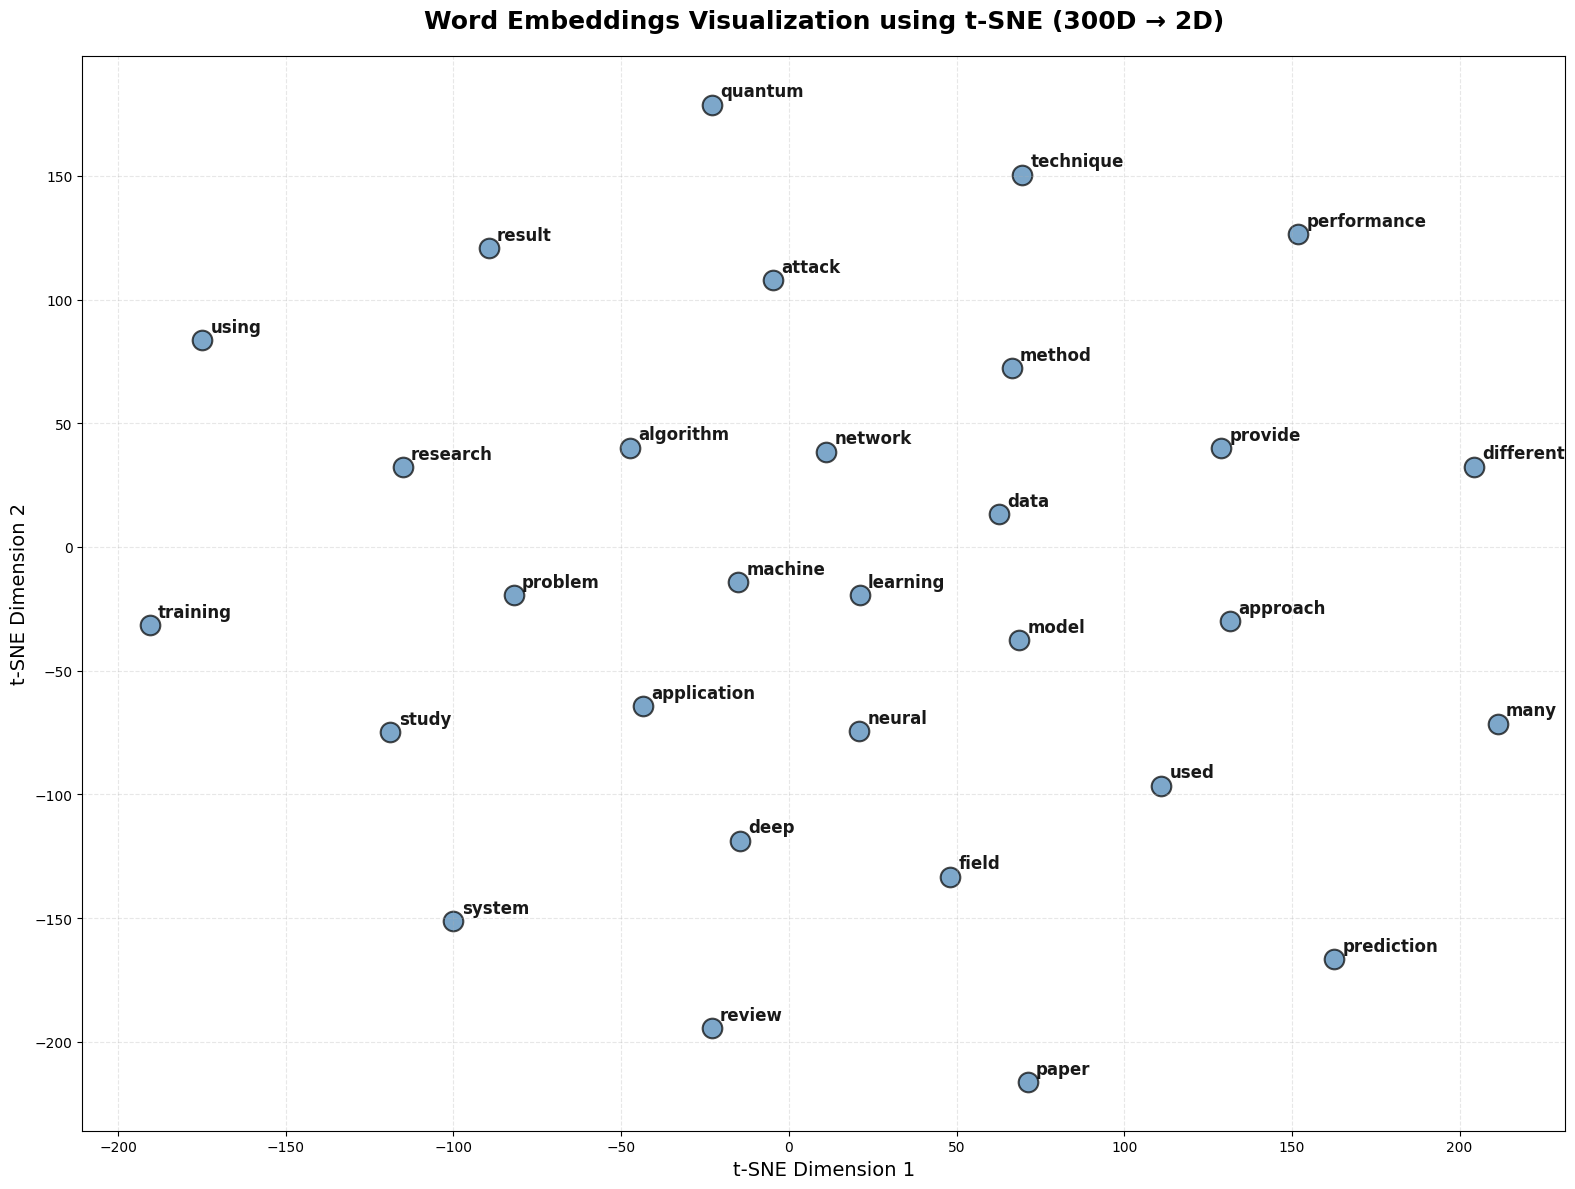

✓ PCA visualization saved: 'word_embeddings_pca.png'


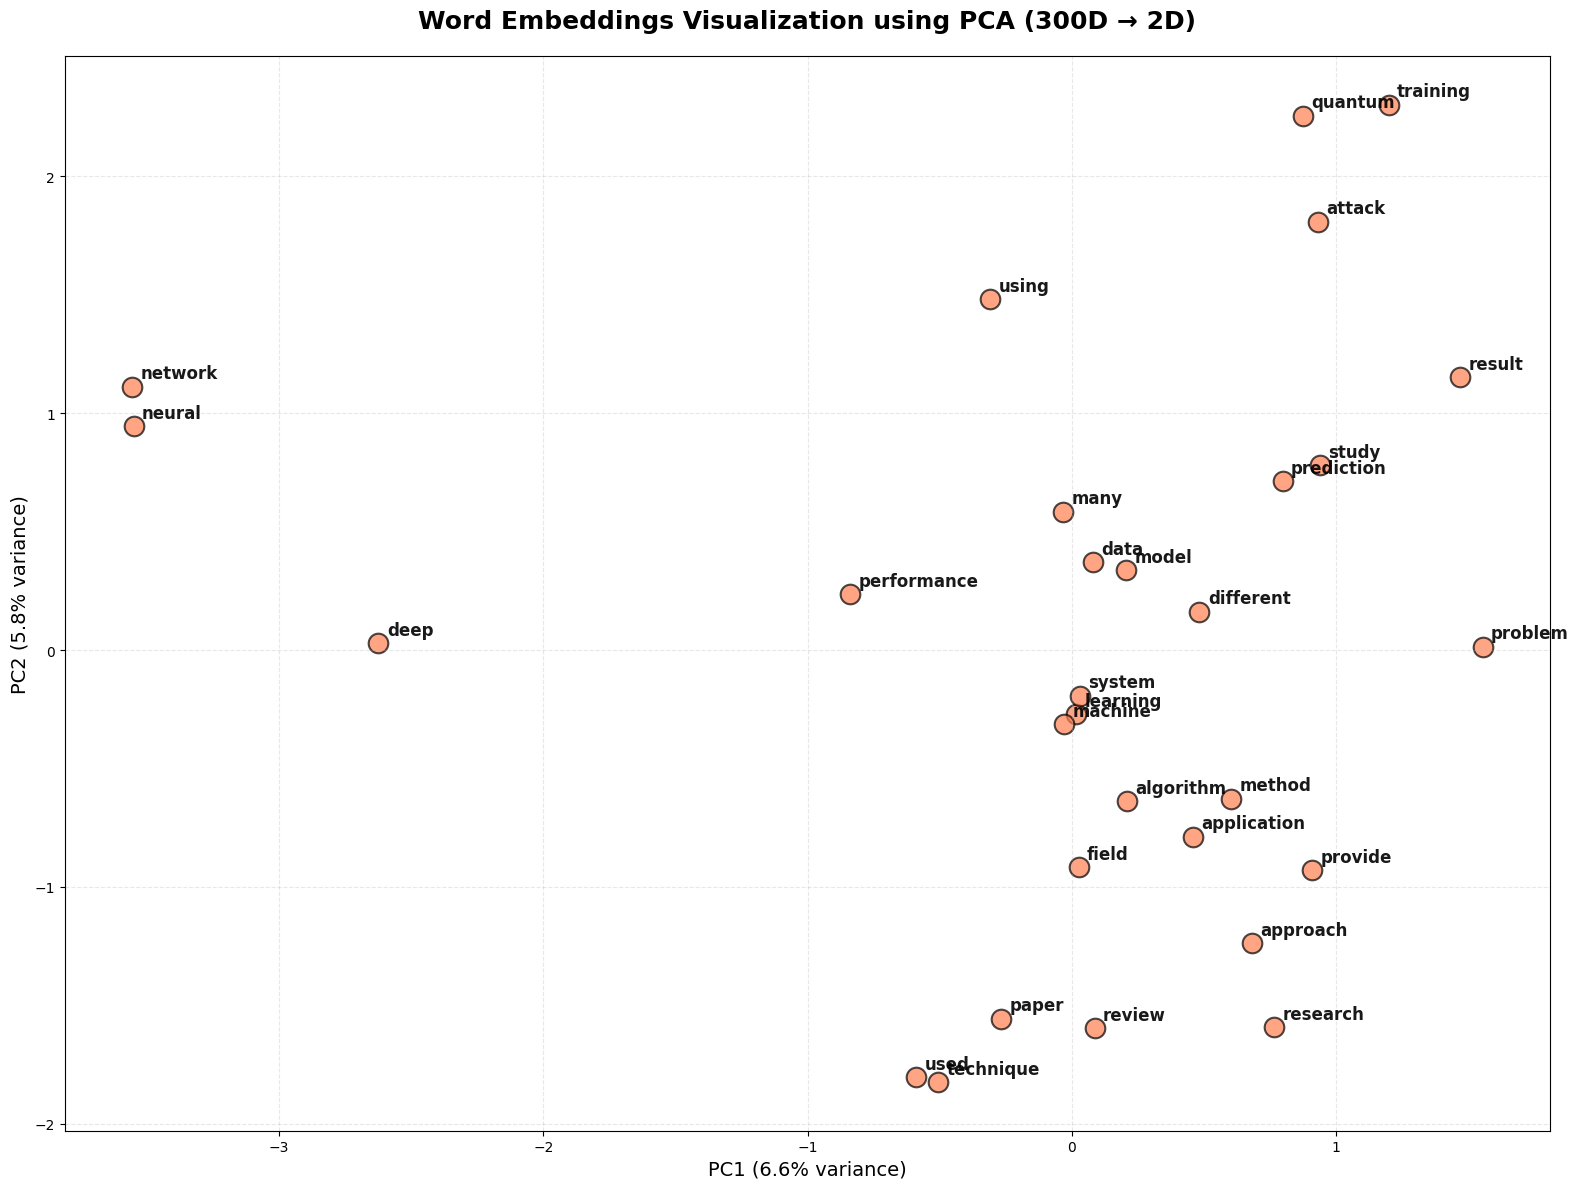


--------------------------------------------------------------------------------
COSINE SIMILARITY BETWEEN WORD PAIRS:
--------------------------------------------------------------------------------

Similarity between 'machine' and 'learning':
  Manual calculation:  0.669654
  Gensim verification: 0.669654

Similarity between 'neural' and 'network':
  Manual calculation:  0.768370
  Gensim verification: 0.768370

Similarity between 'algorithm' and 'model':
  Manual calculation:  0.026542
  Gensim verification: 0.026542

Similarity between 'training' and 'data':
  Manual calculation:  0.171515
  Gensim verification: 0.171515

Similarity between 'deep' and 'learning':
  Manual calculation:  0.235505
  Gensim verification: 0.235505

Similarity between 'artificial' and 'intelligence':
  Manual calculation:  0.862173
  Gensim verification: 0.862173

--------------------------------------------------------------------------------
MOST SIMILAR WORDS:
---------------------------------------

In [3]:
# ============================================================================
# Question 3: Word Embedding Model - FIXED VERSION
# ============================================================================

# Re-import to avoid naming conflicts
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Verify numpy is properly loaded
print(f"NumPy loaded: {type(np)}, version: {np.__version__}")

print("\n" + "="*80)
print("QUESTION 3: WORD EMBEDDING MODEL")
print("="*80)

print("\nPreparing data for Word2Vec...")
tokenized_docs = [preprocess_text(doc) for doc in documents]

# Train Word2Vec model
print("Training Word2Vec model (300 dimensions)...")
w2v_model = Word2Vec(
    sentences=tokenized_docs,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    epochs=100,
    sg=1
)

print(f"✓ Model trained successfully!")
print(f"  Vocabulary size: {len(w2v_model.wv)}")
print(f"  Vector dimensions: {w2v_model.wv.vector_size}")

# Get top frequent words
words_to_plot = list(w2v_model.wv.index_to_key)[:30]

# FIXED: Get word vectors using explicit loop
word_vectors_list = []
for word in words_to_plot:
    word_vectors_list.append(w2v_model.wv[word])
word_vectors = np.array(word_vectors_list)

print(f"\nWord vectors shape: {word_vectors.shape}")
print(f"Visualizing {len(words_to_plot)} words...")

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(15, len(words_to_plot)-1))
embeddings_2d_tsne = tsne.fit_transform(word_vectors)

plt.figure(figsize=(16, 12))
plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1],
           c='steelblue', alpha=0.7, s=200, edgecolors='black', linewidth=1.5)

for i, word in enumerate(words_to_plot):
    plt.annotate(word,
                xy=(embeddings_2d_tsne[i, 0], embeddings_2d_tsne[i, 1]),
                xytext=(6, 6),
                textcoords='offset points',
                fontsize=12,
                fontweight='bold',
                alpha=0.9)

plt.title('Word Embeddings Visualization using t-SNE (300D → 2D)',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('word_embeddings_tsne.png', dpi=300, bbox_inches='tight')
print("✓ t-SNE visualization saved: 'word_embeddings_tsne.png'")
plt.show()
plt.close()

# PCA visualization
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(word_vectors)

plt.figure(figsize=(16, 12))
plt.scatter(embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1],
           c='coral', alpha=0.7, s=200, edgecolors='black', linewidth=1.5)

for i, word in enumerate(words_to_plot):
    plt.annotate(word,
                xy=(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1]),
                xytext=(6, 6),
                textcoords='offset points',
                fontsize=12,
                fontweight='bold',
                alpha=0.9)

plt.title('Word Embeddings Visualization using PCA (300D → 2D)',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=14)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('word_embeddings_pca.png', dpi=300, bbox_inches='tight')
print("✓ PCA visualization saved: 'word_embeddings_pca.png'")
plt.show()
plt.close()

# PART 3: Calculate cosine similarity between word pairs
def manual_cosine_similarity(vec1, vec2):
    """Calculate cosine similarity manually"""
    dot_prod = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_prod / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0

print("\n" + "-"*80)
print("COSINE SIMILARITY BETWEEN WORD PAIRS:")
print("-"*80)

# Define word pairs based on the vocabulary
word_pairs = [
    ('machine', 'learning'),
    ('neural', 'network'),
    ('algorithm', 'model'),
    ('training', 'data'),
    ('deep', 'learning'),
    ('artificial', 'intelligence'),
]

for w1, w2 in word_pairs:
    if w1 in w2v_model.wv and w2 in w2v_model.wv:
        vec1 = w2v_model.wv[w1]
        vec2 = w2v_model.wv[w2]

        sim_manual = manual_cosine_similarity(vec1, vec2)
        sim_gensim = w2v_model.wv.similarity(w1, w2)

        print(f"\nSimilarity between '{w1}' and '{w2}':")
        print(f"  Manual calculation:  {sim_manual:.6f}")
        print(f"  Gensim verification: {sim_gensim:.6f}")
    else:
        print(f"\n'{w1}' or '{w2}' not in vocabulary")

# Find most similar words
print("\n" + "-"*80)
print("MOST SIMILAR WORDS:")
print("-"*80)

sample_words = ['machine', 'learning', 'neural', 'privacy', 'federated']
for word in sample_words:
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=5)
        print(f"\nMost similar to '{word}':")
        for sim_word, score in similar:
            print(f"  {sim_word:25} : {score:.4f}")
    else:
        print(f"\n'{word}' not in vocabulary")

## Question 4 (20 Points)

**Create your own training and evaluation dataset for an NLP task.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.




1.   Which NLP Task you would like perform on your selected dataset
(NER, Summarization, Sentiment Analysis, Text classficication)
2.  Explain your labeling Schema you have used and mention those labels

3.  You can take AI assistance for labeling the data only.



In [4]:
# ============================================================================
# Question 4: Create Annotated Dataset (20 points)
# ============================================================================

print("\n\n" + "="*80)
print("QUESTION 4: ANNOTATED DATASET CREATION")
print("="*80)

print("""
INSTRUCTIONS FOR QUESTION 4:

1. NLP Task Selected: SENTIMENT ANALYSIS (or TOPIC CLASSIFICATION)

2. Labeling Schema for Sentiment Analysis:
   - Label 'positive': Papers with positive outcomes, improvements, advantages
   - Label 'negative': Papers discussing limitations, challenges, problems
   - Label 'neutral':  Papers that are descriptive, surveys, comparisons

   OR for Topic Classification:
   - Label 'machine_learning': General ML papers
   - Label 'privacy': Privacy, security, federated learning
   - Label 'interpretability': Explainability, fairness, transparency
   - Label 'applications': Specific application domains

3. Annotation Process:
   - Read each abstract/cleaned_text
   - Identify the primary focus or sentiment
   - Use consistent labeling criteria
   - You can use AI tools for assistance

4. CSV Format Required:
   - Column 1: document_id (e.g., doc_1, doc_2, ...)
   - Column 2: clean_text (the cleaned_text column data)
   - Column 3: label (your chosen label)
""")

# Create annotated dataset
print("\nCreating annotated dataset...")

# For demonstration - you should manually annotate or use AI assistance
annotated_data = []
for i in range(len(documents)):
    doc_id = f"doc_{i+1}"
    clean_text = documents[i]

    # Example auto-labeling (replace with manual annotation)
    # This is just for demonstration
    text_lower = clean_text.lower()
    if 'privacy' in text_lower or 'federated' in text_lower or 'security' in text_lower:
        label = "privacy"
    elif 'interpretab' in text_lower or 'explain' in text_lower or 'fairness' in text_lower:
        label = "interpretability"
    elif 'image' in text_lower or 'nlp' in text_lower or 'vision' in text_lower:
        label = "applications"
    else:
        label = "machine_learning"

    annotated_data.append({
        'document_id': doc_id,
        'clean_text': clean_text,
        'label': label
    })

df_annotated = pd.DataFrame(annotated_data)

print("\nSample of annotated dataset (first 10 rows):")
print(df_annotated.head(10)[['document_id', 'label']].to_string())

print(f"\nLabel distribution:")
print(df_annotated['label'].value_counts())

# Save to CSV
df_annotated.to_csv('annotated_dataset.csv', index=False)
print("\n✓ Dataset saved as 'annotated_dataset.csv'")

# The GitHub link of your final csv file
# Link:



QUESTION 4: ANNOTATED DATASET CREATION

INSTRUCTIONS FOR QUESTION 4:

1. NLP Task Selected: SENTIMENT ANALYSIS (or TOPIC CLASSIFICATION)

2. Labeling Schema for Sentiment Analysis:
   - Label 'positive': Papers with positive outcomes, improvements, advantages
   - Label 'negative': Papers discussing limitations, challenges, problems
   - Label 'neutral':  Papers that are descriptive, surveys, comparisons

   OR for Topic Classification:
   - Label 'machine_learning': General ML papers
   - Label 'privacy': Privacy, security, federated learning
   - Label 'interpretability': Explainability, fairness, transparency
   - Label 'applications': Specific application domains

3. Annotation Process:
   - Read each abstract/cleaned_text
   - Identify the primary focus or sentiment
   - Use consistent labeling criteria
   - You can use AI tools for assistance

4. CSV Format Required:
   - Column 1: document_id (e.g., doc_1, doc_2, ...)
   - Column 2: clean_text (the cleaned_text column data)
  

# Mandatory Question

Provide your thoughts on the assignment by filling this survey link. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [5]:
# Type your answer